In [168]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
import scipy
from scipy.optimize import fsolve
from math import factorial

In [169]:
fig_width_pt = 246.0  
inches_per_pt = 1.0/72.27             
golden_mean = (np.sqrt(5)-1.0)/2.0    
fig_width = fig_width_pt*inches_per_pt 
fig_height = fig_width/1.5 
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = [fig_width, fig_height]
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['font.family'] = 'times'

In [170]:
M = 3   # number of large JJs in a SNAIL
EJ = 90 * 2*np.pi   # junction energy of larger JJ 
EL = 64 * 2*np.pi   # linear inductive energy of the SNAIL
EC = 177e-3 * 2*np.pi   # charging energy of the SNAIL 
beta = 0.147   # ratio between small and large JJ 
phi_ext = 0.35 * 2*np.pi   # external flux in SNAIL, e.g., 2pi = 1 flux quantum 

w_a = 2.976018 * 2*np.pi   # frequency of Alice mode 
w_b = 6.915945 * 2*np.pi   # frequency of Bob mode 

g_ac = 75.6e-3 * 2*np.pi   # coupling strength between Alice and SNAIL
g_bc = 134.9e-3 * 2*np.pi   # coupling strength between Bob and SNAIL 

chi_a_q = -766e-6 * 2*np.pi   # dispersive shift between Alice and its ancilla transmon
anh_a_q = -181e-3 * 2*np.pi   # anharmonicity of Alice's transmon
chi_b_q = -1104e-6 * 2*np.pi   # dispersive shift between Bob and its ancilla transmon
anh_b_q = -184e-3 * 2*np.pi   # anharmonicity of Bob's transmon

dim_SNAIL = 10   # level cutoff of SNAIL using oscillator basis (expanded around the equilibrium in potential)
dim_alice = 6   # level cutoff of Alice using oscillator basis 
dim_bob = 6   # level cutoff of Bob using oscillator basis 
dim = dim_SNAIL * dim_alice * dim_bob   # total dimension of the coupled system 

In [171]:
c_opt = tensor(qeye(dim_alice), destroy(dim_SNAIL), qeye(dim_bob))   # annihilation operator of SNAIL  
a_opt = tensor(destroy(dim_alice), qeye(dim_SNAIL), qeye(dim_bob))   # annihilation operator of Alice  
b_opt = tensor(qeye(dim_alice), qeye(dim_SNAIL), destroy(dim_bob))   # annihilation operator of Bob  

In [172]:
def potential_min(phi_min, phi_ext):
    return beta * np.sin(phi_min - phi_ext) + np.sin(phi_min/M)

In [173]:
phi_exts = np.linspace(0.0,0.5,100)*2*np.pi

In [174]:
import numpy as np

def state_index(index,dim):
    m,n,k = index
    M,N,K = dim
    return m*(N*K)+n*K+k
def sort_eigenpairs(eigenvalues, eigenvectors):
    n = eigenvectors.shape[0]
    sorted_indices = []

    for i in range(n):
        max_abs_vals = np.abs(eigenvectors[i, :])
        max_index = np.argmax(max_abs_vals)
        while max_index in sorted_indices:
            max_abs_vals[max_index] = -np.inf
            max_index = np.argmax(max_abs_vals)
        sorted_indices.append(max_index)

    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    return sorted_eigenvalues, sorted_eigenvectors

In [195]:
wcs = []
g3s = []
g4s = []
g5s = []
anhs = []
exact_anhs = []
crosskerrs = []
ec1 = []
ec2 = []
ss1 = []
ss2 = []
sk1 = []
sk2 = []
dimss = (dim_alice,dim_SNAIL,dim_bob)
for phi_ext in phi_exts:
    # Taylor coefficients of the expansion around potential minimum [ref. B7]
    phi_min = fsolve(potential_min, 0, args=phi_ext)[0]
    c2 = beta * np.cos(phi_min - phi_ext) + np.cos(phi_min/M)/M
    c3 = (M**2-1)/M**2 * np.sin(phi_min/M)
    c4 = -beta * np.cos(phi_min - phi_ext) - np.cos(phi_min/M)/M**3
    c5 = (1-M**4)/M**4 * np.sin(phi_min/M)

    p = EL / (c2 * EJ + EL)
    
    # renormalized coefficient due to the linear inductor [ref. B9]
    c2_ti = p * c2
    c3_ti = p**3 * c3
    c4_ti = p**4 * (c4 - 3*c3**2/c2*(1-p))
    c5_ti = p**5 *(c5 - 10*c4*c3/c2*(1-p) + 15*c3**3/c2**2*(1-p)**2)

    # zero point fluctuation of the linearized SNAIL
    phi_c = (2*EC / c2_ti / EJ)**0.25

    # analytical approximation of SNAIL nonlinearity and frequency [ref. B8]
    wc = np.sqrt(8*c2_ti*EC*EJ)
    g3 = EJ * phi_c**3 * c3_ti / factorial(3)
    g4 = EJ * phi_c**4 * c4_ti / factorial(4)
    g5 = EJ * phi_c**5 * c5_ti / factorial(5)
    g3s.append(-g3/2/np.pi)
    g4s.append(12*g4/2/np.pi)
    g5s.append(-60*g5/2/np.pi)
    wcs.append(wc/2/np.pi)
    anh = 12 * (g4 - 5 * g3**2/wc)
    anhs.append(anh/2/np.pi)
    # construct the SNAIL Hamiltonian up to 5th order nonlinearity 
    h_SNAIL = wc * c_opt.dag() * c_opt + g3 * (c_opt + c_opt.dag())**3 + g4 * (c_opt + c_opt.dag())**4 +g5 * (c_opt + c_opt.dag())**5 

    # constuct the coupled Alice--SNAIL--Bob Hamiltonian
#     h_tot = h_SNAIL + w_a * a_opt.dag() * a_opt + w_b * b_opt.dag() * b_opt + g_ac * (a_opt.dag()*c_opt + a_opt*c_opt.dag()) + g_bc * (b_opt.dag()*c_opt + b_opt*c_opt.dag())
    h_tot = (h_SNAIL + w_a * a_opt.dag() * a_opt + w_b * b_opt.dag() * b_opt + 
        -1j*g_ac * (a_opt.dag()+a_opt)*(c_opt - c_opt.dag()) -1j* g_bc * (b_opt.dag()+b_opt)*(c_opt - c_opt.dag()))
    h_tot = h_tot.full()
    
    energy,U = np.linalg.eigh(h_tot)
    energy,U = sort_eigenpairs(energy, U)
    energy = energy - energy[0]*np.ones(len(energy))
    omegas = wc
    omega_c1 = w_a
    omega_c2 = w_b
    indexs1 = state_index((0,1,0),dimss)
    energys1 = energy[indexs1]
    indexs2 = indexs1 = state_index((0,2,0),dimss)
    exact_anh = energy[indexs2] - 2*energys1
    exact_anhs.append(exact_anh/2/np.pi)
    
    
    indexc11 = state_index((1,0,0),dimss)
    energyc11 = energy[indexc11]
    indexc12 = state_index((2,0,0),dimss)
    energyc12 = energy[indexc12]
    indexsc11 = state_index((1,1,0),dimss)
    energysc11 = energy[indexsc11]
    starkshift11 = energysc11  - energyc11 - energys1
    selfkerr1 = energyc12 - 2*energyc11
    
    indexc21 = state_index((0,0,1),dimss)
    energyc21 = energy[indexc21]
    indexc22 = state_index((0,0,2),dimss)
    energyc22 = energy[indexc22]
    indexsc21 = state_index((0,1,1),dimss)
    energysc21 = energy[indexsc21]
    starkshift21 = energysc21  - energyc21 - energys1
    selfkerr2 = energyc22 - 2*energyc21
    
    index12 = state_index((1,0,1),dimss)
    energy12 = energy[index12]
    crosskerr = energy12 - energyc11 - energyc21
    crosskerrs.append(crosskerr/2/np.pi)
    ec1.append(energyc11/2/np.pi)
    ec2.append(energyc21/2/np.pi)
    ss1.append(starkshift11/2/np.pi)
    ss2.append(starkshift21/2/np.pi)
    sk1.append(selfkerr1/2/np.pi)
    sk2.append(selfkerr2/2/np.pi)

In [218]:
import qutip as qt
from sympy import symbols
def ec_plug(g3v,g4v,omega_sv,omega_cv):
    ec = qload('./ecrwa')[0]
    ds = qload('./dsrwa')[0]
    sk = qload('./skrwa')[0]
    
    g3 = symbols('g3', real=True)
    g4 = symbols('g4', real=True)
    g5 = symbols('g5', real=True)
    g6 = symbols('g6', real=True)
    omega_a = symbols('omega', real=True)
    omega_b = symbols('omega_1', real=True)
    ecv = float(ec.subs(g3,g3v).subs(g4,g4v).subs(omega_a,omega_sv).subs(omega_b,omega_cv))
    dsv = float(ds.subs(g3,g3v).subs(g4,g4v).subs(omega_a,omega_sv).subs(omega_b,omega_cv))
    skv = float(sk.subs(g3,g3v).subs(g4,g4v).subs(omega_a,omega_sv).subs(omega_b,omega_cv))
    return ecv,dsv,skv
def ck_plug(g3v,g4v,omega_sv,omega_c1v,omega_c2v,g1v,g2v):
    ck = qload('./ckrwa')[0]
    g1 = symbols('g_1', real=True)
    g2 = symbols('g_2', real=True)
    g3 = symbols('g3', real=True)
    g4 = symbols('g4', real=True)
    g5 = symbols('g5', real=True)
    g6 = symbols('g6', real=True)
    omega_a = symbols('omega', real=True)
    omega_b = symbols('omega_c1', real=True)
    omega_c = symbols('omega_c2', real=True)
    ckv = float(ck.subs(g3,g3v).subs(g4,g4v).subs(omega_a,omega_sv).subs(omega_b,omega_c1v).subs(omega_c,omega_c2v).subs(g1,g1v).subs(g2,g2v))
    return ckv

In [219]:
ck = qload('./ckrwa')[0]

In [220]:
g1 = g_ac
g2 = g_bc
appcrosskerrs = []
appec1 = []
appec2 = []
appss1 = []
appss2 = []
appsk1 = []
appsk2 = []
for phi_ext in phi_exts:
    # Taylor coefficients of the expansion around potential minimum [ref. B7]
    phi_min = fsolve(potential_min, 0, args=phi_ext)[0]
    c2 = beta * np.cos(phi_min - phi_ext) + np.cos(phi_min/M)/M
    c3 = (M**2-1)/M**2 * np.sin(phi_min/M)
    c4 = -beta * np.cos(phi_min - phi_ext) - np.cos(phi_min/M)/M**3
    c5 = (1-M**4)/M**4 * np.sin(phi_min/M)

    p = EL / (c2 * EJ + EL)
    
    # renormalized coefficient due to the linear inductor [ref. B9]
    c2_ti = p * c2
    c3_ti = p**3 * c3
    c4_ti = p**4 * (c4 - 3*c3**2/c2*(1-p))
    c5_ti = p**5 *(c5 - 10*c4*c3/c2*(1-p) + 15*c3**3/c2**2*(1-p)**2)

    # zero point fluctuation of the linearized SNAIL
    phi_c = (2*EC / c2_ti / EJ)**0.25

    # analytical approximation of SNAIL nonlinearity and frequency [ref. B8]
    wc = np.sqrt(8*c2_ti*EC*EJ)
    omega_s = wc
    g3 = EJ * phi_c**3 * c3_ti / factorial(3)
    g4 = EJ * phi_c**4 * c4_ti / factorial(4)
    g5 = EJ * phi_c**5 * c5_ti / factorial(5)
    ecc1,ds1,skk1 = ec_plug(g3,g4,wc,omega_c1)
    ecc2,ds2,skk2 = ec_plug(g3,g4,wc,omega_c2)  
    ckv = ck_plug(g3,g4,wc,omega_c1,omega_c2,g1,g2) 
    energyc11 = omega_c1+g1**2*ecc1
    energyc21 = omega_c2+g2**2*ecc2
    
    selfkerr1 =g1**4*skk1
    starkshift11 = g1**2*ds1

    selfkerr2 =g2**4*skk2
    starkshift21 = g2**2*ds2
    appcrosskerrs.append(ckv/2/np.pi)
    appec1.append(energyc11/2/np.pi)
    appec2.append(energyc21/2/np.pi)
    appss1.append(starkshift11/2/np.pi)
    appss2.append(starkshift21/2/np.pi)
    appsk1.append(selfkerr1/2/np.pi)
    appsk2.append(selfkerr2/2/np.pi)

In [221]:
g1 = g_ac
g2 = g_bc
bappcrosskerrs = []
bappec1 = []
bappec2 = []
bappss1 = []
bappss2 = []
bappsk1 = []
bappsk2 = []
for phi_ext in phi_exts:
    # Taylor coefficients of the expansion around potential minimum [ref. B7]
    phi_min = fsolve(potential_min, 0, args=phi_ext)[0]
    c2 = beta * np.cos(phi_min - phi_ext) + np.cos(phi_min/M)/M
    c3 = (M**2-1)/M**2 * np.sin(phi_min/M)
    c4 = -beta * np.cos(phi_min - phi_ext) - np.cos(phi_min/M)/M**3
    c5 = (1-M**4)/M**4 * np.sin(phi_min/M)

    p = EL / (c2 * EJ + EL)
    
    # renormalized coefficient due to the linear inductor [ref. B9]
    c2_ti = p * c2
    c3_ti = p**3 * c3
    c4_ti = p**4 * (c4 - 3*c3**2/c2*(1-p))
    c5_ti = p**5 *(c5 - 10*c4*c3/c2*(1-p) + 15*c3**3/c2**2*(1-p)**2)

    # zero point fluctuation of the linearized SNAIL
    phi_c = (2*EC / c2_ti / EJ)**0.25

    # analytical approximation of SNAIL nonlinearity and frequency [ref. B8]
    wc = np.sqrt(8*c2_ti*EC*EJ)
    omega_s = wc
    g3 = EJ * phi_c**3 * c3_ti / factorial(3)
    g4 = EJ * phi_c**4 * c4_ti / factorial(4)
    g5 = EJ * phi_c**5 * c5_ti / factorial(5)

    energyc11 = omega_c1 + g1**2/(omega_c1-omega_s)
    energyc21 = omega_c2 + g2**2/(omega_c2-omega_s)
    
    omegap = 1/((8*omega_c1**2-3*omega_s**2)/(omega_s*(2*omega_c1-omega_s)*(omega_s+2*omega_c1)))
    selfkerr1 =(12*g4 - 36*g3**2/omega_s*(omega_s/omegap))*(g1/(omega_s-omega_c1))**4
    omegap = 1/((omega_c1**2-6*omega_s**2)/(omega_s*(omega_c1-2*omega_s)*(2*omega_s+omega_c1)))
    ratio = omega_s/omegap
    starkshift11 = 24*(g4-3*g3**2/omega_s*omega_s/omegap)*(g1/(omega_s-omega_c1))**2
    
    omegap = 1/((8*omega_c2**2-3*omega_s**2)/(omega_s*(2*omega_c2-omega_s)*(omega_s+2*omega_c2)))
    selfkerr2 =(12*g4 - 36*g3**2/omega_s*(omega_s/omegap))*(g2/(omega_s-omega_c2))**4
    omegap = 1/((omega_c2**2-6*omega_s**2)/(omega_s*(omega_c2-2*omega_s)*(2*omega_s+omega_c2)))
    ratio = omega_s/omegap
    starkshift21 = 24*(g4-3*g3**2/omega_s*omega_s/omegap)*(g2/(omega_s-omega_c2))**2
    omegap =1/(1/(omega_c1-omega_c2-omega_s)+1/(-omega_c1+omega_c2-omega_s)+1/(omega_c1+omega_c2-omega_s)+1/(-omega_c1-omega_c2-omega_s))
    crosskerr = (24*g4-72*g3**2/omega_s*(-omega_s/omegap)/2)*(g1/(omega_s-omega_c1))**2*(g2/(omega_s-omega_c2))**2
    bappcrosskerrs.append(crosskerr/2/np.pi)
    bappec1.append(energyc11/2/np.pi)
    bappec2.append(energyc21/2/np.pi)
    bappss1.append(starkshift11/2/np.pi)
    bappss2.append(starkshift21/2/np.pi)
    bappsk1.append(selfkerr1/2/np.pi)
    bappsk2.append(selfkerr2/2/np.pi)

(0.4, 0.5)

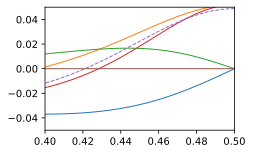

In [222]:
plt.plot(phi_exts/2/np.pi,np.array(g3s))
plt.plot(phi_exts/2/np.pi,np.array(g4s))
plt.plot(phi_exts/2/np.pi,np.array(g5s))
plt.plot(phi_exts/2/np.pi,np.array(anhs))
plt.plot(phi_exts/2/np.pi,np.array(exact_anhs),'--')
plt.plot(phi_exts/2/np.pi,0*np.array(anhs))
plt.ylim(-0.05,0.05)
plt.xlim(0.4,0.5)

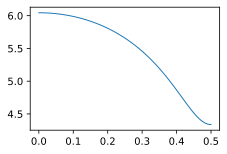

In [223]:
plt.plot(phi_exts/2/np.pi,np.array(wcs))

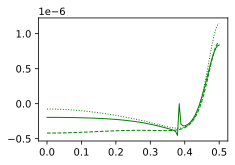

In [228]:
color = 'green'
plt.plot(phi_exts/2/np.pi,np.array(crosskerrs),color = color )
plt.plot(phi_exts/2/np.pi,np.array(appcrosskerrs),linestyle = 'dotted',color  = color )
plt.plot(phi_exts/2/np.pi,np.array(bappcrosskerrs),'--',color = color )
# plt.ylim(-1e-6,1e-6)

(2.971, 2.975)

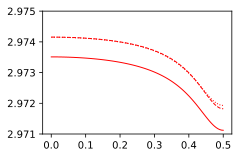

In [183]:

plt.plot(phi_exts/2/np.pi,ec1,color = colora)
plt.plot(phi_exts/2/np.pi,appec1,linestyle = 'dotted',color = colora)
plt.plot(phi_exts/2/np.pi,bappec1,'--',color = colora)
plt.ylim(2.971,2.975)

(6.92, 6.94)

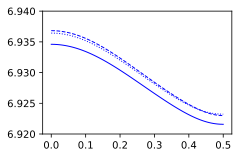

In [135]:

plt.plot(phi_exts/2/np.pi,ec2,color = colorb)
plt.plot(phi_exts/2/np.pi,appec2,linestyle = 'dotted',color = colorb)
plt.plot(phi_exts/2/np.pi,bappec2,'--',color = colorb)

plt.ylim(6.920,6.940)

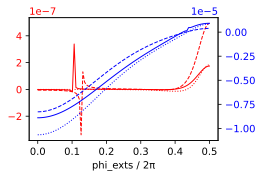

In [131]:
fig, ax1 = plt.subplots()

# First set of plots for the primary y-axis
ax1.plot(phi_exts/2/np.pi, sk1, label='sk1', color=colora)
ax1.plot(phi_exts/2/np.pi, appsk1, linestyle='dotted', label='appsk1', color=colora)
ax1.plot(phi_exts/2/np.pi, bappsk1, linestyle='--', label='bappsk1', color=colora)
ax1.set_xlabel('phi_exts / 2π')
# ax1.set_ylabel('Values for sk1, appsk1, bappsk1', color=colora)
ax1.tick_params(axis='y', labelcolor=colora)

# Create a twin y-axis for the second set of data
ax2 = ax1.twinx()
ax2.plot(phi_exts/2/np.pi, sk2, label='sk2', color=colorb)
ax2.plot(phi_exts/2/np.pi, appsk2, linestyle='dotted', label='appsk2', color=colorb)
ax2.plot(phi_exts/2/np.pi, bappsk2, linestyle='--', label='bappsk2', color=colorb)
# ax2.set_ylabel('Values for sk2, appsk2, bappsk2', color=colorb)
ax2.tick_params(axis='y', labelcolor=colorb)

# # Legends
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')

plt.show()

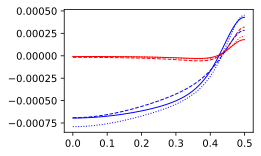

In [129]:

colora = 'red' 
colorb = 'blue' 
plt.plot(phi_exts/2/np.pi,ss1,color = colora)
plt.plot(phi_exts/2/np.pi,appss1,linestyle = 'dotted',color = colora)
plt.plot(phi_exts/2/np.pi,bappss1,'--',color = colora)
plt.plot(phi_exts/2/np.pi,ss2,color = colorb)
plt.plot(phi_exts/2/np.pi,appss2,linestyle = 'dotted',color = colorb)
plt.plot(phi_exts/2/np.pi,bappss2,'--',color = colorb)
